# **Pre-Installation**

In [ ]:
!pip install transformers timm seaborn openai fastapi_poe
!pip install absl-py torch torchvision numpy scipy scikit-learn fastapi python-dotenv
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'

# **args_pool**

In [ ]:
ALL_ID_DATASET = [
    'bird200', 'pet37', 'cub100_ID', 'pet18_ID', 'cifar10_ID'
]

ALL_OOD_TASK = [
    'far', 'fine_grained', 'near'
]

ALL_LLM = [
    'gpt-3.5-turbo', 'gpt-3.5-turbo-16k', 'gpt-4'
]

dataset_mappings = {
    'bird200': ['dtd'],
    'pet37': ['dtd'],
    'cub100_ID': ['cub100_OOD'],
    'pet18_ID': ['pet19_OOD'],
    'cifar10_ID': ['cifar100_OOD']
}

# **common**

In [ ]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import json
import random
import ast
import logging

seed = 5

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_test_labels(args, loader=None):
    if args.in_dataset in ['bird200', 'pet37', 'cub100_ID', 'pet18_ID']:
        test_labels = loader.dataset.class_names_str
    elif args.in_dataset in ['dtd', 'cifar10_ID', 'cifar100_OOD']:
        test_labels = loader.dataset.classes
    else:
        raise ValueError(f"Unknown dataset for labels: {args.in_dataset}")
    return test_labels

def get_num_cls(args):
    NUM_CLS_DICT = {
        'bird200': 200,
        'pet37': 37,
        'dtd': 47,
        'cub100_ID': 100,
        'cub100_OOD': 100,
        'pet18_ID': 18,
        'pet19_OOD': 19,
        'cifar10_ID': 10,
        'cifar100_OOD': 100,
    }
    try:
        n_cls = NUM_CLS_DICT[args.in_dataset]
    except KeyError:
        raise ValueError(f"Unknown dataset: {args.in_dataset}")
    return n_cls


# **imagenet-template (only if ensemble activated)**

In [ ]:
openai_imagenet_template_subset = {
    0: [
    lambda c: f'a photo of a {c}.',
    lambda c: f'a blurry photo of a {c}.',
    lambda c: f'a photo of many {c}.',
    lambda c: f'a photo of the large {c}.',
    lambda c: f'a photo of the small {c}.',
    ],
}

# **detection util**

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import sklearn.metrics as sk
from transformers import CLIPTokenizer
import torch.nn.functional as F

def clip_text_ens(net, tokenizer, test_labels, prompt_pool):
    prompts = [template(label) for label in test_labels for template in prompt_pool]
    text_inputs = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    )
    features = net.get_text_features(
        input_ids=text_inputs['input_ids'].cuda(),
        attention_mask=text_inputs['attention_mask'].cuda()
    ).float()

    text_features = torch.zeros(len(test_labels), features.shape[1]).cuda()
    num_templates = len(prompt_pool)
    for i in range(len(test_labels)):
        for j in range(num_templates):
            idx = i * num_templates + j
            normed = features[idx] / features[idx].norm(dim=-1, keepdim=True)
            text_features[i] += normed
    return text_features

def pre_filter(net, tokenizer, test_labels, gpt_labels, args, prompt_pool=None):
    net.eval()
    if not args.ensemble:
        test_prompts = [f"a photo of a {c}" for c in test_labels]
        gpt_prompts  = [f"a photo of a {c}" for c in gpt_labels]

        test_in = tokenizer(
            test_prompts,
            padding=True,
            truncation=True,
            max_length=tokenizer.model_max_length,
            return_tensors="pt"
        )
        gpt_in  = tokenizer(
            gpt_prompts,
            padding=True,
            truncation=True,
            max_length=tokenizer.model_max_length,
            return_tensors="pt"
        )

        test_feats = net.get_text_features(
            input_ids=test_in['input_ids'].cuda(),
            attention_mask=test_in['attention_mask'].cuda()
        ).float()
        gpt_feats  = net.get_text_features(
            input_ids=gpt_in['input_ids'].cuda(),
            attention_mask=gpt_in['attention_mask'].cuda()
        ).float()

    else:
        test_feats = clip_text_ens(net, tokenizer, test_labels, prompt_pool)
        gpt_feats  = clip_text_ens(net, tokenizer, gpt_labels,  prompt_pool)

    return torch.cat((test_feats, gpt_feats), dim=0)

def remove_overlap_class(test_labels, gpt_labels):
    words_set = {word for phrase in test_labels for word in phrase.split()}
    gpt_labels = [phrase for phrase in gpt_labels if not any(word in words_set for word in phrase.split())]

    return gpt_labels

def get_ood_scores_clip(args, net, loader, test_labels, gpt_labels, softmax = True):
    net.eval()
    to_np = lambda x: x.data.cpu().numpy()
    concat = lambda x: np.concatenate(x, axis=0)
    _score = []
    id_class_nums = len(test_labels)
    if args.model == 'CLIP':
        tokenizer = CLIPTokenizer.from_pretrained(args.ckpt)

    tqdm_object = tqdm(loader, total=len(loader))
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm_object):
            labels = labels.long().cuda()
            images = images.cuda()

            image_features = net.get_image_features(pixel_values = images).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            if args.score in ['MCM', 'energy', 'max-logit']:
                if not args.ensemble:
                    text_inputs = tokenizer([f"a photo of a {c}" for c in test_labels], padding=True, return_tensors="pt")
                    text_features = net.get_text_features(input_ids = text_inputs['input_ids'].cuda(),
                                                    attention_mask = text_inputs['attention_mask'].cuda()).float()
                else:
                    text_features = clip_text_ens(net, tokenizer, test_labels)
                text_features /= text_features.norm(dim=-1, keepdim=True)
                output = image_features @ text_features.T
            elif args.score == 'EOE':
                if args.ood_task == 'near':
                    gpt_labels = remove_overlap_class(test_labels, gpt_labels)
                total_features = pre_filter(net, tokenizer, test_labels, gpt_labels, args)
                total_features /= total_features.norm(dim=-1, keepdim=True)
                output = image_features @ total_features.T

            if softmax:
                smax = to_np(F.softmax(output/ args.T, dim=1))
            else:
                smax = to_np(output/ args.T)

            # cal score
            if args.score == 'EOE':
                if args.score_ablation == 'EOE':
                    smax = np.max(smax[:, :id_class_nums], axis=1) - args.beta * np.max(smax[:, id_class_nums:], axis=1)
                    _score.append(-smax)
                elif args.score_ablation == 'MAX':
                    iid_values, iid_indices = torch.max(output[:, :id_class_nums], dim=1)
                    ood_values, ood_indices = torch.max(output[:, id_class_nums:], dim=1)
                    condition = ood_values > iid_values
                    output[:, :id_class_nums][condition] = 1/id_class_nums
                    output = output[:, :id_class_nums]
                    smax = to_np(F.softmax(output/ args.T, dim=1))
                    smax = np.max(smax[:, :id_class_nums], axis=1)
                    _score.append(-smax)
                elif args.score_ablation == 'MSP':
                    smax = np.max(smax[:, :id_class_nums], axis=1)
                    _score.append(-smax)
                elif args.score_ablation == 'energy':
                    _score.append(-to_np((args.T*torch.logsumexp(output[:, :id_class_nums] / args.T, dim=1)) - (args.T*torch.logsumexp(output[:, id_class_nums:] / args.T, dim=1))))
                elif args.score_ablation == 'max-logit':
                    _score.append(-to_np(torch.max(output[:, :id_class_nums], 1)[0] - torch.max(output[:, id_class_nums:], 1)[0]))
                else:
                    raise NotImplementedError
            elif args.score == 'MCM':
                _score.append(-np.max(smax, axis=1))
            elif args.score == 'energy':
                #Energy = - T * logsumexp(logit_k / T), by default T = 1 in https://arxiv.org/pdf/2010.03759.pdf
                _score.append(-to_np((args.T*torch.logsumexp(output / args.T, dim=1))))  #energy score is expected to be smaller for ID
            elif args.score == 'max-logit':
                _score.append(-to_np(torch.max(output, 1)[0]))

    return concat(_score)[:len(loader.dataset)].copy()

# Metric Calculations
def stable_cumsum(arr, rtol=1e-05, atol=1e-08):
    out = np.cumsum(arr, dtype=np.float64)
    expected = np.sum(arr, dtype=np.float64)
    if not np.allclose(out[-1], expected, rtol=rtol, atol=atol):
        raise RuntimeError('unstable cumsum')
    return out

def fpr_and_fdr_at_recall(y_true, y_score, recall_level=0.95, pos_label=1):
    y_true = (y_true == pos_label)
    desc_score_indices = np.argsort(y_score)[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    tps = stable_cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    recall = tps / tps[-1]
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)
    recall, fps = np.r_[recall[sl], 1], np.r_[fps[sl], 0]
    return fps[np.argmin(np.abs(recall - recall_level))] / np.sum(~y_true)

def get_measures(pos, neg, recall_level=0.95):
    pos = np.array(pos).reshape((-1, 1))
    neg = np.array(neg).reshape((-1, 1))
    examples = np.squeeze(np.vstack((pos, neg)))
    labels = np.zeros(len(examples), dtype=np.int32)
    labels[:len(pos)] = 1
    auroc = sk.roc_auc_score(labels, examples)
    aupr = sk.average_precision_score(labels, examples)
    fpr = fpr_and_fdr_at_recall(labels, examples, recall_level)
    return auroc, aupr, fpr

# Final Evaluation Output Printed
def get_and_print_results(args, log, in_score, out_score, auroc_list, aupr_list, fpr_list):
    auroc, aupr, fpr = get_measures(-in_score, -out_score)
    auroc_list.append(auroc)
    aupr_list.append(aupr)
    fpr_list.append(fpr)
    print_measures(log, auroc, aupr, fpr, args.score)

def print_measures(log, auroc, aupr, fpr, method_name='Ours', recall_level=0.95):
    if log is None:
        print(f'FPR{int(100 * recall_level)}:\t\t\t{100 * fpr:.2f}')
        print(f'AUROC: \t\t\t{100 * auroc:.2f}')
        print(f'AUPR:  \t\t\t{100 * aupr:.2f}')
    else:
        log.debug('\t\t\t\t' + method_name)
        log.debug(f'  FPR{int(100 * recall_level)} AUROC AUPR')
        log.debug(f'& {100*fpr:.2f} & {100*auroc:.2f} & {100*aupr:.2f}')

# **file_ops**

In [ ]:
def save_scores(args, scores, dataset_name):
    os.makedirs(args.log_directory, exist_ok=True)
    with open(os.path.join(args.log_directory, f'{dataset_name}_scores.npy'), 'wb') as f:
        np.save(f, scores)

# prevent any recomputation
def load_scores(args, dataset_name):
    with open(os.path.join(args.log_directory, f'{dataset_name}_scores.npy'), 'rb') as f:
        scores = np.load(f)
    return scores

def setup_log(args):
    log = logging.getLogger(__name__)
    if not log.handlers:
        formatter = logging.Formatter('%(asctime)s : %(message)s')
        fileHandler = logging.FileHandler(os.path.join(args.log_directory, "ood_eval_info.log"), mode='w')
        fileHandler.setFormatter(formatter)
        streamHandler = logging.StreamHandler()
        streamHandler.setFormatter(formatter)
        log.setLevel(logging.DEBUG)
        log.addHandler(fileHandler)
        log.addHandler(streamHandler)
        log.debug(f"#########{args.name}############")
    return log

def save_as_dataframe(args, out_datasets, fpr_list, auroc_list, aupr_list):
    os.makedirs(args.log_directory, exist_ok=True)
    fpr_list = [float('{:.2f}'.format(100*fpr)) for fpr in fpr_list]
    auroc_list = [float('{:.2f}'.format(100*auroc)) for auroc in auroc_list]
    aupr_list = [float('{:.2f}'.format(100*aupr)) for aupr in aupr_list]
    import pandas as pd
    data = {k:v for k,v in zip(out_datasets, zip(fpr_list,auroc_list,aupr_list))}
    data['AVG'] = [np.mean(fpr_list),np.mean(auroc_list),np.mean(aupr_list) ]
    data['AVG']  = [float('{:.2f}'.format(metric)) for metric in data['AVG']]
    df = pd.DataFrame.from_dict(data, orient='index',
                       columns=['FPR95', 'AUROC', 'AUPR'])
    df.to_csv(os.path.join(args.log_directory,f'{args.name}_{args.json_number}.csv'))

# **prompt_pool**

In [ ]:
class PromptGenerator:
    def __init__(self):
        self.dataset_info = {
            'bird200': {'class_type': None, 'num_classes': 200},
            'pet37': {'class_type': None, 'num_classes': 37},
            'cub100_ID': {'class_type': 'bird', 'num_classes': 100},
            'dtd47': {'class_type': 'texture', 'num_classes': 47},
            'pet18_ID': {'class_type': 'pet (including dogs and cats)', 'num_classes': 18},
            'cifar10_ID': {'class_type': None, 'num_classes': 10},
        }

    def _fine_grained_prompt(self, class_type, num_classes, class_info, envision_nums=50):
        return f"""Q: I have a dataset containing 10 unique species of dogs. I need a list of 10 distinct dog species that are NOT present in my dataset, and ensure there are no repetitions in the list you provide. For context, the species in my dataset are: ['husky dog', 'alaskan Malamute', 'cossack sled dog', 'golden retriever', 'German Shepherd', 'Beagle', 'Bulldog', 'Poodle', 'Dachshund', 'Doberman Pinscher']
        A: The other 10 dog species not in the dataset are:
        - Labrador Retriever
        - Rottweiler
        - Boxer
        - Border Collie
        - Shih Tzu
        - Akita
        - Saint Bernard
        - Australian Shepherd
        - Great Dane
        - Boston Terrier

        Q: I have a dataset containing {num_classes} different species of {class_type}. I need a list of {envision_nums} distinct {class_type} species that are NOT present in my dataset, and ensure there are no repetitions in the list you provide. For context, the species in my dataset are: {class_info}
        A: The other {envision_nums} {class_type} species not in the dataset are:
        """

    def _far_prompt(self, class_type, num_classes, class_info, envision_nums=50):
       return f"""Q: I have gathered images of 4 distinct categories: ['Husky dog', 'Garfield cat', 'churches', 'truck'].
       Summarize what broad categories these categories might fall into based on visual features.
       Now, I am looking to identify 5 categories that visually resemble to these broad categories but have no direct relation to these broad categories.
       Please list these 5 items for me.
        A: These 5 items are:
        - black stone
        - mountain
        - Ginkgo Tree
        - river
        - Rapeseed

        Q: I have gathered images of {num_classes} distinct categories: [{class_info}].
        Summarize what broad categories these categories might fall into based on visual features.
        Now, I am looking to identify {envision_nums} classes that visually resemble to these broad categories but have no direct relation to these broad categories.
        Please list these {envision_nums} items for me.
        A: These {envision_nums} items are:
        """

    def _near_prompt(self, class_type, num_classes, class_info, envision_nums=3):
        return f"""Q: Given the image category [husky dog], please suggest visually similar categories that are not directly related or belong to the same primary group as [husky dog]. Provide suggestions that share visual characteristics but are from broader and different domains than [husky dog].
        A: There are 3 classes similar to [husky dog], and they are from broader and different domains than [husky dog]:
        - gray wolf
        - black stone
        - red panda

        Q: Given the image category [basketball], please suggest visually similar categories that are not directly related or belong to the same primary group as [basketball]. Provide suggestions that share visual characteristics but are from broader and different domains than [basketball].
        A: There are 3 classes similar to [basketball], and they are from broader and different domains than [basketball]:
        - balloons
        - blowfish
        - hat

        Q: Given the image category [water jug], please suggest visually similar categories that are not directly related or belong to the same primary group as [water jug]. Provide suggestions that share visual characteristics but are from broader and different domains than [water jug].
        A: There are 3 classes similar to [water jug], and they are from broader and different domains than [water jug]:
        - trumpets
        - helmets
        - rucksacks

        Q: Given the image category [{class_info}], please suggest visually similar categories that are not directly related or belong to the same primary group as [{class_info}]. Provide suggestions that share visual characteristics but are from broader and different domains than [{class_info}].
        A: There are {envision_nums} classes similar to [{class_info}], and they are from broader and different domains than [{class_info}]:
        """

    def _fine_grained_prompt_again(self, in_dataset, envision_nums=50):
        dataset_info = self.dataset_info[in_dataset]
        class_type = dataset_info["class_type"]
        num_classes = dataset_info["num_classes"]
        return f"""Q: Provide {envision_nums} additional {class_type} categories that aren't in the set I gave you, and haven't been mentioned in your previous responses to me.
A: The {envision_nums} additional categories are:
"""

    def _far_prompt_again(self, in_dataset, envision_nums=50):
        return f"""Q: Give me {envision_nums} more categories that are visually similar to these broad categories you summarized in the dataset but have no direct relation to these broad categories. Each category you give cannot exceed three words and could not have appeared in your previous answers.
A: The other {envision_nums} categories are:
"""

    def get_prompt(self, ood_task, in_dataset, class_info=None, envision_nums=50):
        prompt_dispatcher = {
            'fine_grained': self._fine_grained_prompt,
            'far': self._far_prompt,
            'near': self._near_prompt
        }
        if ood_task not in prompt_dispatcher:
            raise ValueError("Unknown OOD task")
        info = self.dataset_info[in_dataset]
        return prompt_dispatcher[ood_task](info["class_type"], info["num_classes"], class_info, envision_nums)

    def get_prompt_again(self, ood_task, in_dataset, class_info=None, envision_nums=50):
        prompt_dispatcher = {
            'fine_grained': self._fine_grained_prompt_again,
            'far': self._far_prompt_again,
        }
        if ood_task not in prompt_dispatcher:
            raise ValueError("Unknown OOD task")
        return prompt_dispatcher[ood_task](in_dataset, envision_nums)

# **generate_llm_class**

In [ ]:
import os
import json
import itertools
import fastapi_poe
import asyncio
import openai
from dotenv import load_dotenv
import re

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

def stringtolist(description):
    lines = description.split("\n")
    candidates = []
    for line in lines:
        line = line.strip()
        bullet_match = re.match(r"^[-•*]\s+(.*)", line)
        number_match = re.match(r"^\d+[\.\)]\s+(.*)", line)

        if bullet_match:
            candidates.append(bullet_match.group(1).strip())
        elif number_match:
            candidates.append(number_match.group(1).strip())
    return candidates

def get_next_number(args, folder_path):
    files = os.listdir(folder_path)
    numbers = []
    for file in files:
        if file.startswith(f"{args.in_dataset}_{args.llm_model}") and file.endswith(".json"):
            try:
                number = int(file.split('_')[-1].split('.')[0])
                numbers.append(number)
            except ValueError:
                pass

    return 0 if not numbers else max(numbers) + 1

def load_json(filename):
    if not filename.endswith('.json'):
        filename += '.json'
    with open(filename, 'r') as fp:
        return json.load(fp)

client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def get_completion(args, prompt):
    try:
        response = client.chat.completions.create(
            model=args.llm_model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""

def get_completion_from_messages(args, context, new_prompt):
    try:
        context.append({"role": "user", "content": new_prompt})
        response = client.chat.completions.create(
            model=args.llm_model,
            messages=context,
            temperature=0.0,
        )
        generated_text = response.choices[0].message.content
        context.append({"role": "assistant", "content": generated_text})
        return generated_text, context
    except Exception as e:
        print(f"An error occurred: {e}")
        return "", context

def load_llm_classes(args, test_labels):
    assert args.ood_task in ['far', 'fine_grained', 'near'], "Only 'far' and 'fine_grained' supported"
    if args.ood_task in ['far', 'fine_grained']:
      assert args.L in [50, 100, 300, 500], "L must be one of [50, 100, 300, 500] for far/fine_grained"
    elif args.ood_task == 'near':
      assert args.L in [1, 3, 10], "L must be one of [1, 3, 10] for near"

    folder_path = os.path.join("envisioned_classes", f'{args.ood_task}_{args.L}')
    os.makedirs(folder_path, exist_ok=True)

    if args.generate_class:
        print('Envisioning Outlier Exposure...')
        json_number = get_next_number(args, folder_path)
        file_path = os.path.join(folder_path, f"{args.in_dataset}_{args.llm_model}_{json_number}.json")
        asyncio.run(obtain_gpt_class_and_save(args, file_path, test_labels))
    else:
        file_path = os.path.join(folder_path, f"{args.in_dataset}_{args.llm_model}_{args.json_number}.json")

    print('=== load json: ', file_path)
    gpt_class_dict = load_json(file_path)
    print('Get Envisioned Candidate Class Names.')

    gpt_class = []
    for value in gpt_class_dict.values():
        gpt_class.extend(value)

    # Normalize and remove duplicates and overlap with test set
    gpt_class = [item.lower() for item in gpt_class]
    gpt_class = list(set(gpt_class))
    print('After set:', len(gpt_class))

    test_labels = [item.lower() for item in test_labels]
    gpt_class = [item for item in gpt_class if item not in test_labels]
    print('After removing ID class overlaps:', len(gpt_class))

    return gpt_class

async def obtain_gpt_class_and_save(args, file_path, class_list):
    assert args.ood_task in ['far', 'fine_grained', 'near'], "Only 'far', 'fine_grained', or 'near' supported"

    # Adjust L constraint depending on task
    if args.ood_task in ['far', 'fine_grained']:
        assert args.L in [50, 100, 300, 500], "L must be one of [50, 100, 300, 500] for far/fine_grained"
        envision_nums = 50
        envision_times = max(int(args.L / envision_nums) - 1, 0)
    elif args.ood_task == 'near':
        assert args.L in [1, 3, 5, 10], "L must be small (e.g. [1, 3, 5, 10]) for near task"
        envision_nums = args.L
        envision_times = 0

    prompt_gen = PromptGenerator()

    # === NEAR TASK: prompt per class ===
    if args.ood_task == 'near':
        descriptors = {}
        response_texts = []
        for cls in class_list:
            prompt = prompt_gen.get_prompt(
                ood_task='near',
                in_dataset=args.in_dataset,
                class_info=cls,
                envision_nums=envision_nums
            )
            print(f"\n Prompt for class '{cls}':\n{prompt}\n")
            response = get_completion(args, prompt)
            response_texts.append(response)
            descriptors[cls] = stringtolist(response)

        print(f"\n Raw GPT output for all classes:\n{response_texts}")

    # === FAR or FINE_GRAINED: single prompt with multiple batches ===
    else:
        prompt = prompt_gen.get_prompt(
            ood_task=args.ood_task,
            in_dataset=args.in_dataset,
            class_info=class_list,
            envision_nums=envision_nums
        )
        print("Generating via OpenAI GPT...")
        response_texts = get_completion(args, prompt)

        context = [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response_texts}
        ]

        for i in range(envision_times):
            print(f"Continuing vision {i + 1}/{envision_times}")
            new_prompt = prompt_gen.get_prompt_again(
                ood_task=args.ood_task,
                in_dataset=args.in_dataset,
                class_info=class_list,
                envision_nums=envision_nums
            )
            generated_text, context = get_completion_from_messages(args, context, new_prompt)
            response_texts += generated_text

        print(" Raw GPT output:\n", response_texts)
        descriptors_list = stringtolist(response_texts)
        descriptors = {args.ood_task: descriptors_list}

    # === Save Output ===
    print(f"\n Saving hallucinated class descriptors to: {file_path}")
    with open(file_path, 'w') as fp:
        json.dump(descriptors, fp)

# **plot_util**

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

class Args:
    def __init__(self):
        self.log_directory = "results/test_plot"
        self.score = "EOE"

args = Args()

def plot_distribution(args, id_scores, ood_scores, out_dataset):
    sns.set(style="white", palette="muted")
    palette = ['#8E8BFE', '#FEA3A2']

    import pandas as pd
    data = pd.DataFrame({
        "Score": np.concatenate([-1 * id_scores, -1 * ood_scores]),
        "Type": ["ID"] * len(id_scores) + ["OOD"] * len(ood_scores)
    })

    # Plot with seaborn
    plt.figure(figsize=(6, 4))
    sns.kdeplot(
        data=data,
        x="Score",
        hue="Type",
        fill=True,
        palette=palette,
        alpha=0.8,
        linewidth=2
    )

    # Add axis labels and ticks
    plt.xlabel("Score", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    # Save the figure
    os.makedirs(args.log_directory, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(args.log_directory, f"{args.score}_{out_dataset}.png"))
    plt.show()

# **dataloaders/cub200.py**

In [ ]:
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset
import numpy as np
import pickle


class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'

    def __init__(self, root, train=True, transform=None, loader=default_loader):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        self._load_metadata()

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

        class_names = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'classes.txt'),
                                         sep=' ', names=['class_id', 'target'])
        self.class_names_str = [name.split(".")[1].replace('_', ' ') for name in class_names.target]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target



class Cub100(Cub2011):
    def __init__(self, root, train=True, id=True, transform=None, loader=default_loader):
        self.id = id
        self.root = root
        self._select_or_load_classes()
        super().__init__(root, train, transform, loader)

    def _select_or_load_classes(self):
        subset_classes_file = os.path.join('data', 'CUB-100', "selected_100_classes.pkl")
        if os.path.exists(subset_classes_file):
            with open(subset_classes_file, 'rb') as f:
                self.selected_classes = pickle.load(f)
        else:
            all_classes = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'classes.txt'),
                                      sep=' ', names=['class_id', 'target'])
            selected_class_ids = np.random.choice(all_classes['class_id'], 100, replace=False)
            self.selected_classes = all_classes[all_classes['class_id'].isin(selected_class_ids)]['target'].tolist()
            # self.selected_classes = all_classes['target'].iloc[:100].tolist()
            with open(subset_classes_file, 'wb') as f:
                pickle.dump(self.selected_classes, f)

    def _load_metadata(self):
        super()._load_metadata()

        all_classes = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'classes.txt'),
                              sep=' ', names=['class_id', 'target'])

        selected_class_ids = all_classes[all_classes['target'].isin(self.selected_classes)]['class_id'].tolist()

        if self.id: # select cub100_iid
            self.data = self.data[self.data['target'].isin(selected_class_ids)]
            self.class_names_str = [name.split(".")[1].replace('_', ' ') for name in self.selected_classes]

            remaining_class_ids = set(all_classes['class_id']) - set(selected_class_ids)
            remaining_class_names = all_classes[all_classes['class_id'].isin(remaining_class_ids)]['target'].tolist()
            self.ood_class_name_str = [name.split(".")[1].replace('_', ' ') for name in remaining_class_names]
        else:  # select cub100_ood
            remaining_class_ids = set(all_classes['class_id']) - set(selected_class_ids)
            self.data = self.data[self.data['target'].isin(remaining_class_ids)]
            remaining_class_names = all_classes[all_classes['class_id'].isin(remaining_class_ids)]['target'].tolist()
            self.class_names_str = [name.split(".")[1].replace('_', ' ') for name in remaining_class_names]

# **datasets/pet37.py**

In [ ]:
import os
import os.path

from typing import Any, Tuple, Callable, Optional, Union, Sequence
import torch
import pickle
import random
from PIL import Image
import pathlib
from torchvision.datasets.utils import download_and_extract_archive, verify_str_arg
from torchvision.datasets.vision import VisionDataset


class OxfordIIITPet(VisionDataset):
    _RESOURCES = (
        ("https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", "5c4f3ee8e5d25df40f4fd59a7f44e54c"),
        ("https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", "95a8c909bbe2e81eed6a22bccdf3f68f"),
    )
    _VALID_TARGET_TYPES = ("category", "segmentation")

    def __init__(
        self,
        root: str,
        split: str = "trainval",
        target_types: Union[Sequence[str], str] = "category",
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ):
        self._split = verify_str_arg(split, "split", ("trainval", "test"))
        if isinstance(target_types, str):
            target_types = [target_types]
        self._target_types = [
            verify_str_arg(target_type, "target_types", self._VALID_TARGET_TYPES) for target_type in target_types
        ]

        super().__init__(root, transforms=transforms, transform=transform, target_transform=target_transform)
        self._base_folder = pathlib.Path(self.root) / "oxford-iiit-pet"
        self._images_folder = self._base_folder / "images"
        self._anns_folder = self._base_folder / "annotations"
        self._segs_folder = self._anns_folder / "trimaps"

        if download:
            self._download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found. You can use download=True to download it")

        image_ids = []
        self._labels = []
        with open(self._anns_folder / f"{self._split}.txt") as file:
            for line in file:
                image_id, label, *_ = line.strip().split()
                image_ids.append(image_id)
                self._labels.append(int(label) - 1)

        self.classes = [
            " ".join(part.title() for part in raw_cls.split("_"))
            for raw_cls, _ in sorted(
                {(image_id.rsplit("_", 1)[0], label) for image_id, label in zip(image_ids, self._labels)},
                key=lambda image_id_and_label: image_id_and_label[1],
            )
        ]
        self.class_to_idx = dict(zip(self.classes, range(len(self.classes))))

        self._images = [self._images_folder / f"{image_id}.jpg" for image_id in image_ids]
        self._segs = [self._segs_folder / f"{image_id}.png" for image_id in image_ids]

        self.class_names_str = self.classes

    def __len__(self) -> int:
        return len(self._images)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        image = Image.open(self._images[idx]).convert("RGB")

        target: Any = []
        for target_type in self._target_types:
            if target_type == "category":
                target.append(self._labels[idx])
            else:  # target_type == "segmentation"
                target.append(Image.open(self._segs[idx]))

        if not target:
            target = None
        elif len(target) == 1:
            target = target[0]
        else:
            target = tuple(target)

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


    def _check_exists(self) -> bool:
        for folder in (self._images_folder, self._anns_folder):
            if not (os.path.exists(folder) and os.path.isdir(folder)):
                return False
        else:
            return True

    def _download(self) -> None:
        if self._check_exists():
            return

        for url, md5 in self._RESOURCES:
            download_and_extract_archive(url, download_root=str(self._base_folder), md5=md5)


class OxfordIIITPet_18(OxfordIIITPet):
    def __init__(self,
        root: str,
        split: str = "trainval",
        id: bool = True,
        target_types: Union[Sequence[str], str] = "category",
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
        ):
        super(OxfordIIITPet_18, self).__init__(root=root, split=split, target_types=target_types, transforms=transforms, transform=transform, target_transform=target_transform, download=download)

        subset_classes_file = os.path.join('data', 'Oxford-Pet-18', 'selected_18_classes.pkl')
        if os.path.exists(subset_classes_file):
            with open(subset_classes_file, 'rb') as f:
                stored_classes = pickle.load(f)
        else:
            stored_classes = random.sample(self.classes, 18)
            with open(subset_classes_file, 'wb') as f:
                pickle.dump(stored_classes, f)

        selected_classes = stored_classes if id else [cls for cls in self.classes if cls not in stored_classes]
        self.ood_class_name_str = [cls for cls in self.classes if cls not in stored_classes] if id else stored_classes

        selected_indices = [i for i, label in enumerate(self._labels) if self.classes[label] in selected_classes]
        self._images = [self._images[i] for i in selected_indices]
        self._segs = [self._segs[i] for i in selected_indices]
        self._labels = [self._labels[i] for i in selected_indices]

        self.classes = selected_classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.class_names_str = self.classes


def examine_count(counter, name = "train"):
    print(f"in the {name} set")
    for label in counter:
        print(label, counter[label])

# **train_eval_util**

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from transformers import CLIPModel
from torchvision.datasets import CIFAR10, CIFAR100

def set_model_clip(args):
    """Load the CLIP model and corresponding val transforms"""
    ckpt_mapping = {
        "ViT-B/16": "openai/clip-vit-base-patch16",
        "ViT-B/32": "openai/clip-vit-base-patch32",
        "ViT-L/14": "openai/clip-vit-large-patch14"
    }
    args.ckpt = ckpt_mapping[args.CLIP_ckpt]
    model = CLIPModel.from_pretrained(args.ckpt)

    normalize = transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                                     std=(0.26862954, 0.26130258, 0.27577711))
    val_preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return model.cuda(), val_preprocess

def set_val_loader(args, preprocess):
    """Create a dataloader for the selected ID dataset"""
    dataset_classes = {
        "bird200": lambda root, transform: Cub2011(root, train=False, transform=transform),
        "pet37": lambda root, transform: OxfordIIITPet(root, split="test", download=True, transform=transform),
        "cub100_ID": lambda root, transform: Cub100(root, train=False, id=True, transform=transform),
        "pet18_ID": lambda root, transform: OxfordIIITPet_18(root, split="test", id=True, download=True, transform=transform),
        "cifar10_ID": lambda root, transform: CIFAR10(root, train=False, download=True, transform=transform),
    }

    dataset_fn = dataset_classes.get(args.in_dataset)
    if dataset_fn is None:
        raise NotImplementedError(f"Unsupported ID dataset: {args.in_dataset}")

    return torch.utils.data.DataLoader(
        dataset_fn(args.root_dir, preprocess),
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

def set_ood_loader(args, out_dataset, preprocess):
    """Create a DataLoader for the selected OOD dataset."""
    dataset_paths = {
        'dtd': os.path.join(args.root_dir, 'dtd','dtd','images'),
    }

    ood_classes = {
        'bird200':  lambda root, tf: Cub2011(root, train=False, transform=tf),
        'pet37':    lambda root, tf: OxfordIIITPet(root, split='test', download=True, transform=tf),
        'cub100_OOD': lambda root, tf: Cub100(root, train=False, id=False, transform=tf),
        'pet19_OOD': lambda root, tf: OxfordIIITPet_18(root, split='test', id=False, download=True, transform=tf),
        'cifar100_OOD': lambda root, tf: CIFAR100(root, train=False, download=True, transform=tf),
    }

    if out_dataset in dataset_paths:
        dataset = datasets.ImageFolder(dataset_paths[out_dataset], transform=preprocess)
    elif out_dataset in ood_classes:
        dataset = ood_classes[out_dataset](args.root_dir, preprocess)
    else:
        raise ValueError(f"Unsupported OOD dataset: {out_dataset}")

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=getattr(args, 'num_workers', 4),
        pin_memory=getattr(args, 'pin_memory', True)
    )


# **RUN EVALUATION CUB-100(ID) vs CUB-100(OOD) at Beta=0.25 & 0.75,L=0,50,100,300**

In [ ]:
import os
import openai
import re

client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def fetch_synonym(name: str) -> str:
    system_prompt = (
        "You are a fine-grained classification assistant. "
        "When given a pet(including dogs and cats) species name, reply with *exactly one* known synonym or scientific name or name in other language. "
        "If no widely used alternative exists, reply with the original label and do not return *none*. "
        "Only return the name. Do not include explanations, punctuation, or prefixes.\n\n"
        "Here are a few examples:\n"
        "Input: American Goldfinch → Output: Eastern Goldfinch\n"
        "Input: Indigo Bunting → Output: Passerina cyanea\n"
        "Input: Bengal Cat → Output: Leopardette"
        "Input: Gadwall → Output: Anas strepera\n"
    )

    user_prompt = f"Class label: {name}"

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": user_prompt}
        ],
        temperature=0
    )

    raw = response.choices[0].message.content.strip()

    if ":" in raw:
        raw = raw.split(":")[-1].strip()
    if "known as" in raw:
        raw = re.split(r"known as", raw, flags=re.IGNORECASE)[-1].strip()

    return raw.rstrip(".")

In [ ]:
import os
os.environ['CURL_CA_BUNDLE'] = ''
import argparse
import numpy as np
import torch
from scipy import stats

def main():
    args = process_args()
    setup_seed(args.seed)
    log = setup_log(args)
    assert torch.cuda.is_available()
    torch.cuda.set_device(args.gpu)

    net, preprocess = set_model_clip(args)
    net.eval()

    if args.in_dataset.startswith("ImageNet_C"):
        out_datasets = ['iNaturalist', 'SUN', 'places365', 'dtd']
    elif args.in_dataset == 'ImageNet':
        out_datasets = ['iNaturalist', 'SUN', 'places365', 'dtd'] if args.ood_task.startswith("far") else ['ssb_hard', 'ninco']
    else:
        out_datasets = dataset_mappings.get(args.in_dataset, [])

    test_loader = set_val_loader(args, preprocess)
    test_labels = list(get_test_labels(args, test_loader))
    print("Original ID Labels:", test_labels)

    if args.score == 'EOE':
        print("Using LLM-generated OOD candidate classes...")
        base_ood_labels = load_llm_classes(args, test_labels)

        if args.use_synonyms:
            print("Augmenting OOD candidates with synonyms...")

            base_ood_labels = [lbl.strip().lower() for lbl in base_ood_labels]
            original_count = len(base_ood_labels)

            synonym_labels = []
            for lbl in base_ood_labels:
                syn = fetch_synonym(lbl).strip().lower()
                print(f"  → {lbl!r}  → synonym: {syn!r}")
                if syn != lbl:
                    synonym_labels.append(syn)

            combined = base_ood_labels + synonym_labels

            filtered = [label for label in combined if label and label.lower() not in {"none", "null"}]

            removed_count = len(combined) - len(filtered)
            print(f"Removed {removed_count} invalid synonym labels like 'none' or 'null'")

            llm_labels = list(dict.fromkeys(filtered))
            final_count = len(llm_labels)

            print(f"OOD classes before synonym expansion: {original_count}")
            print(f"OOD classes after synonym + deduplication: {final_count}")
        else:
            llm_labels = base_ood_labels
    else:
        llm_labels = []

    print(f"\n Final ID Labels passed to CLIP: {test_labels}")
    print(f"OOD candidate labels: {llm_labels}\n")

    in_score = get_ood_scores_clip(args, net, test_loader, test_labels, llm_labels)

    auroc_list, aupr_list, fpr_list = [], [], []
    for out_dataset in out_datasets:
        log.debug(f"Evaluating OOD dataset {out_dataset}")
        ood_loader = set_ood_loader(args, out_dataset, preprocess)
        out_score = get_ood_scores_clip(args, net, ood_loader, test_labels, llm_labels)

        log.debug(f"in scores: {stats.describe(in_score)}")
        log.debug(f"out scores: {stats.describe(out_score)}")
        plot_distribution(args, in_score, out_score, out_dataset)
        get_and_print_results(args, log, in_score, out_score, auroc_list, aupr_list, fpr_list)

    log.debug('\n\n Mean Test Results')
    print_measures(log, np.mean(auroc_list), np.mean(aupr_list),
                   np.mean(fpr_list), method_name=args.score)

    save_as_dataframe(args, out_datasets, fpr_list, auroc_list, aupr_list)


def process_args():
    parser = argparse.ArgumentParser(
        description='Leverage LLMs for OOD Detection',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument('--in_dataset',
                        default='bird200',
                        choices=ALL_ID_DATASET,
                        help='in-distribution dataset')
    parser.add_argument('--root_dir',
                        default="datasets",
                        help='root dir of datasets')
    # prompt pipeline
    parser.add_argument('--ensemble',
                        action='store_true',
                        default=False,
                        help='CLIP text prompt engineering')
    parser.add_argument('--L',
                        type=int,
                        default=100,
                        help='the length of envisioned OOD class labels, for far/fine-grained: L=500, for near: L=3')
    parser.add_argument('--beta',
                        type=float,
                        default=0.25,
                        help='beta in Eq. 3')
    parser.add_argument('--ood_task',
                        type=str,
                        default='far',
                        choices=ALL_OOD_TASK,
                        help='choose ood task')
    parser.add_argument('--generate_class',
                        action='store_true',
                        help='whether to envision OOD candidate classes or loaded from existing JSONs')
    parser.add_argument('--json_number',
                        type=int,
                        default=0,
                        help='loaded json number')
    parser.add_argument('--llm_model',
                        default="gpt-3.5-turbo",
                        choices=ALL_LLM,
                        help='LLMs')
    parser.add_argument('--name',
                        default="eval_ood",
                        help="unique ID for the run")
    parser.add_argument('--seed',
                        type=int,
                        default=5,
                        help="random seed")
    parser.add_argument('--gpu',
                        type=int,
                        default=0,
                        help='the GPU indice to use')
    parser.add_argument('--batch_size',
                        type=int,
                        default=512,
                        help='mini-batch size')
    parser.add_argument('--T',
                        type=float,
                        default=1,
                        help='score temperature parameter')
    parser.add_argument('--model',
                        default='CLIP',
                        choices=['CLIP'],
                        help='model architecture')
    parser.add_argument('--CLIP_ckpt',
                        default='ViT-B/16',
                        choices=['ViT-B/16'],
                        help='which pretrained img encoder to use')
    parser.add_argument('--score',
                        default='EOE',
                        choices=['EOE', 'MCM', 'energy', 'max-logit'],
                        help='which scoring method')
    parser.add_argument('--score_ablation',
                        default='EOE',
                        choices=['MAX', 'MSP', 'energy', 'max-logit', 'EOE'],
                        help='ablations on the EOE score formula')
    parser.add_argument('--feat_dim',
                        type=int,
                        default=512,
                        help='feat dim, 512 for ViT-B and 768 for ViT-L')
    parser.add_argument('--use_synonyms',
                    default=False,
                    action='store_true',
                    help='Augment ID labels with synonyms using LLM')
    parser.add_argument('--prompt_pool_id',
                    type=int,
                    default=0,
                    help='Which index of openai_imagenet_template_subset to use when --ensemble')
    args = parser.parse_args()

    args.n_cls = get_num_cls(args)
    args.log_directory = f"results/{args.in_dataset}/{args.score}/" \
                         f"{args.model}_{args.CLIP_ckpt}_T_{args.T}_ID_{args.name}"
    os.makedirs(args.log_directory, exist_ok=True)

    return args

L = 0 (MCM)

2025-07-13 06:43:41,338 : #########CUB100_CUB100_MCM_finegrained_evaluation############
DEBUG:__main__:#########CUB100_CUB100_MCM_finegrained_evaluation############


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Laysan Albatross', 'Groove billed Ani', 'Crested Auklet', 'Parakeet Auklet', 'Rusty Blackbird', 'Bobolink', 'Indigo Bunting', 'Painted Bunting', 'Spotted Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'American Crow', 'Purple Finch', 'Acadian Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Gadwall', 'American Goldfinch', 'Boat tailed Grackle', 'Eared Grebe', 'Horned Grebe', 'Pied billed Grebe', 'Blue Grosbeak', 'Evening Grosbeak', 'Pine Grosbeak', 'Rose breasted Grosbeak', 'Pigeon Guillemot', 'Glaucous winged Gull', 'Herring Gull', 'Ivory Gull', 'Ring billed Gull', 'Anna Hummingbird', 'Pomarine Jaeger', 'Blue Jay', 'Green Jay', 'Gray Kingbird', 'Ringed Kingfisher', 'Red legged Kittiwake', 'Horned Lark', 'Western Meadowlark', 'Red breasted Merganser', 'White breasted Nuthatch', 'Hooded Oriole', 'Or

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


100%|██████████| 12/12 [04:42<00:00, 23.55s/it]
2025-07-13 06:48:37,755 : Evaluating OOD dataset cub100_OOD
DEBUG:__main__:Evaluating OOD dataset cub100_OOD
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 12/12 [04:38<00:00, 23.18s/it]
2025-07-13 06:53:16,550 : in scores: DescribeResult(nobs=2895, minmax=(np.float32(-0.012273153), np.float32(-0.010566115)), mean=np.float32(-0.01134112), variance=np.float64(7.342798104171848e-08), skewness=np.float64(-0.333705872297287), kurtosis=np.float32(0.058603287))
DEBUG:__main__:in scores: DescribeResult(nobs=2895, minmax=(np.flo

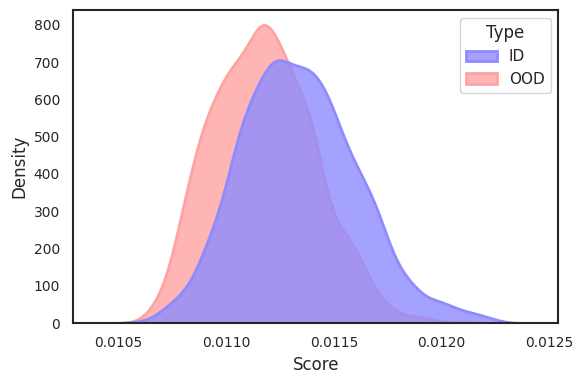

2025-07-13 06:53:16,956 : 				MCM
DEBUG:__main__:				MCM
2025-07-13 06:53:16,958 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 06:53:16,962 : & 83.72 & 67.50 & 67.78
DEBUG:__main__:& 83.72 & 67.50 & 67.78
2025-07-13 06:53:16,964 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 06:53:16,965 : 				MCM
DEBUG:__main__:				MCM
2025-07-13 06:53:16,967 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 06:53:16,969 : & 83.72 & 67.50 & 67.78
DEBUG:__main__:& 83.72 & 67.50 & 67.78


In [ ]:
!pip install -q nest_asyncio
import nest_asyncio
nest_asyncio.apply()
import os
os.environ['CURL_CA_BUNDLE'] = ''
import argparse
import numpy as np
import torch
from scipy import stats
import sys

sys.argv = [
    "eval_ood_detection.py",
    "--name",        "CUB100_CUB100_MCM_finegrained_evaluation",
    "--in_dataset",  "cub100_ID",
    "--ood_task",    "fine_grained",
    "--score",       "MCM",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "50",
]
main()

L=50, Beta=0.25

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Laysan Albatross', 'Groove billed Ani', 'Crested Auklet', 'Parakeet Auklet', 'Rusty Blackbird', 'Bobolink', 'Indigo Bunting', 'Painted Bunting', 'Spotted Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'American Crow', 'Purple Finch', 'Acadian Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Gadwall', 'American Goldfinch', 'Boat tailed Grackle', 'Eared Grebe', 'Horned Grebe', 'Pied billed Grebe', 'Blue Grosbeak', 'Evening Grosbeak', 'Pine Grosbeak', 'Rose breasted Grosbeak', 'Pigeon Guillemot', 'Glaucous winged Gull', 'Herring Gull', 'Ivory Gull', 'Ring billed Gull', 'Anna Hummingbird', 'Pomarine Jaeger', 'Blue Jay', 'Green Jay', 'Gray Kingbird', 'Ringed Kingfisher', 'Red legged Kittiwake', 'Horned Lark', 'Western Meadowlark', 'Red breasted Merganser', 'White breasted Nuthatch', 'Hooded Oriole', 'Or

100%|██████████| 12/12 [00:48<00:00,  4.01s/it]
2025-07-13 06:54:17,136 : Evaluating OOD dataset cub100_OOD
DEBUG:__main__:Evaluating OOD dataset cub100_OOD
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 12/12 [00:46<00:00,  3.89s/it]
2025-07-13 06:55:04,805 : in scores: DescribeResult(nobs=2895, minmax=(np.float32(-0.012273153), np.float32(-0.010566115)), mean=np.float32(-0.01134112), variance=np.float64(7.342798104171848e-08), skewness=np.float64(-0.333705872297287), kurtosis=np.float32(0.058603287))
DEBUG:__main__:in scores: DescribeResult(nobs=2895, minmax=(np.floa

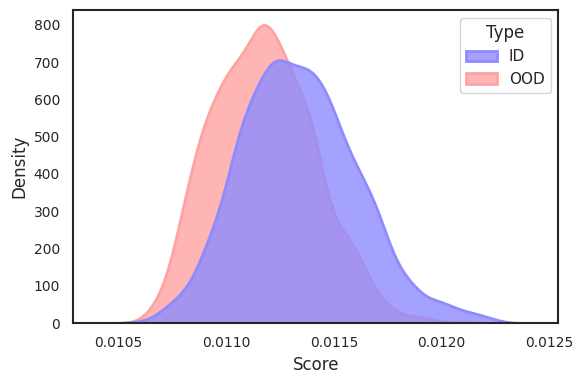

2025-07-13 06:55:06,331 : 				MCM
DEBUG:__main__:				MCM
2025-07-13 06:55:06,336 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 06:55:06,343 : & 83.72 & 67.50 & 67.78
DEBUG:__main__:& 83.72 & 67.50 & 67.78
2025-07-13 06:55:06,348 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 06:55:06,354 : 				MCM
DEBUG:__main__:				MCM
2025-07-13 06:55:06,361 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 06:55:06,367 : & 83.72 & 67.50 & 67.78
DEBUG:__main__:& 83.72 & 67.50 & 67.78


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "CUB100_CUB100_50L_25B_finegrained_evaluation",
    "--in_dataset",  "cub100_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "50",
    "--generate_class",
]
main()

L=100, Beta=0.25

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Laysan Albatross', 'Groove billed Ani', 'Crested Auklet', 'Parakeet Auklet', 'Rusty Blackbird', 'Bobolink', 'Indigo Bunting', 'Painted Bunting', 'Spotted Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'American Crow', 'Purple Finch', 'Acadian Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Gadwall', 'American Goldfinch', 'Boat tailed Grackle', 'Eared Grebe', 'Horned Grebe', 'Pied billed Grebe', 'Blue Grosbeak', 'Evening Grosbeak', 'Pine Grosbeak', 'Rose breasted Grosbeak', 'Pigeon Guillemot', 'Glaucous winged Gull', 'Herring Gull', 'Ivory Gull', 'Ring billed Gull', 'Anna Hummingbird', 'Pomarine Jaeger', 'Blue Jay', 'Green Jay', 'Gray Kingbird', 'Ringed Kingfisher', 'Red legged Kittiwake', 'Horned Lark', 'Western Meadowlark', 'Red breasted Merganser', 'White breasted Nuthatch', 'Hooded Oriole', 'Or

100%|██████████| 12/12 [00:47<00:00,  4.00s/it]
2025-07-13 06:56:16,920 : Evaluating OOD dataset cub100_OOD
DEBUG:__main__:Evaluating OOD dataset cub100_OOD
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 12/12 [00:43<00:00,  3.64s/it]
2025-07-13 06:57:01,119 : in scores: DescribeResult(nobs=2895, minmax=(np.float32(-0.0049603647), np.float32(-0.0041304063)), mean=np.float32(-0.004518271), variance=np.float64(1.553223920363119e-08), skewness=np.float64(0.027345487847924232), kurtosis=np.float32(-0.06919241))
DEBUG:__main__:in scores: DescribeResult(nobs=2895, minmax=(np

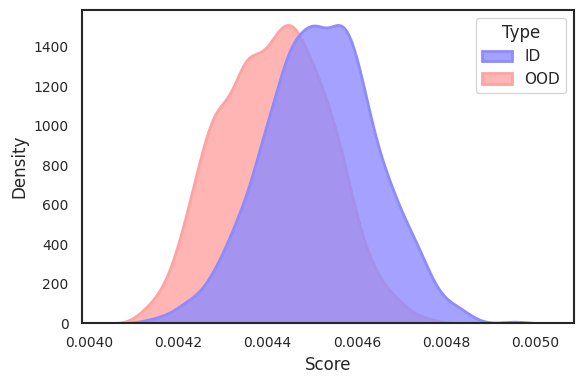

2025-07-13 06:57:01,447 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 06:57:01,450 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 06:57:01,453 : & 77.99 & 72.21 & 72.16
DEBUG:__main__:& 77.99 & 72.21 & 72.16
2025-07-13 06:57:01,456 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 06:57:01,458 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 06:57:01,459 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 06:57:01,461 : & 77.99 & 72.21 & 72.16
DEBUG:__main__:& 77.99 & 72.21 & 72.16


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "CUB100_CUB100_100L_25B_finegrained_evaluation",
    "--in_dataset",  "cub100_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "100",
    "--generate_class",
]
main()

L=300, Beta=0.25

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Laysan Albatross', 'Groove billed Ani', 'Crested Auklet', 'Parakeet Auklet', 'Rusty Blackbird', 'Bobolink', 'Indigo Bunting', 'Painted Bunting', 'Spotted Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'American Crow', 'Purple Finch', 'Acadian Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Gadwall', 'American Goldfinch', 'Boat tailed Grackle', 'Eared Grebe', 'Horned Grebe', 'Pied billed Grebe', 'Blue Grosbeak', 'Evening Grosbeak', 'Pine Grosbeak', 'Rose breasted Grosbeak', 'Pigeon Guillemot', 'Glaucous winged Gull', 'Herring Gull', 'Ivory Gull', 'Ring billed Gull', 'Anna Hummingbird', 'Pomarine Jaeger', 'Blue Jay', 'Green Jay', 'Gray Kingbird', 'Ringed Kingfisher', 'Red legged Kittiwake', 'Horned Lark', 'Western Meadowlark', 'Red breasted Merganser', 'White breasted Nuthatch', 'Hooded Oriole', 'Or

100%|██████████| 12/12 [00:49<00:00,  4.17s/it]
2025-07-13 06:58:23,579 : Evaluating OOD dataset cub100_OOD
DEBUG:__main__:Evaluating OOD dataset cub100_OOD
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 12/12 [00:44<00:00,  3.67s/it]
2025-07-13 06:59:08,050 : in scores: DescribeResult(nobs=2895, minmax=(np.float32(-0.0036452846), np.float32(-0.0029806742)), mean=np.float32(-0.0033202842), variance=np.float64(9.187580615672792e-09), skewness=np.float64(0.10945691168308258), kurtosis=np.float32(0.2684729))
DEBUG:__main__:in scores: DescribeResult(nobs=2895, minmax=(np.f

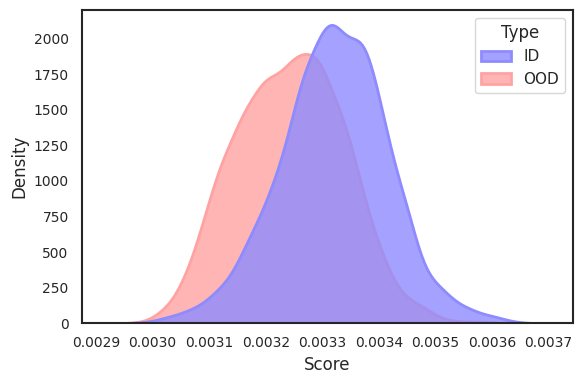

2025-07-13 06:59:08,751 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 06:59:08,757 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 06:59:08,767 : & 79.68 & 71.63 & 70.52
DEBUG:__main__:& 79.68 & 71.63 & 70.52
2025-07-13 06:59:08,773 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 06:59:08,780 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 06:59:08,788 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 06:59:08,795 : & 79.68 & 71.63 & 70.52
DEBUG:__main__:& 79.68 & 71.63 & 70.52


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "CUB100_CUB100_300L_25B_finegrained_evaluation",
    "--in_dataset",  "cub100_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "300",
    "--generate_class",
]
main()

L=50, Beta=0.75

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Laysan Albatross', 'Groove billed Ani', 'Crested Auklet', 'Parakeet Auklet', 'Rusty Blackbird', 'Bobolink', 'Indigo Bunting', 'Painted Bunting', 'Spotted Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'American Crow', 'Purple Finch', 'Acadian Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Gadwall', 'American Goldfinch', 'Boat tailed Grackle', 'Eared Grebe', 'Horned Grebe', 'Pied billed Grebe', 'Blue Grosbeak', 'Evening Grosbeak', 'Pine Grosbeak', 'Rose breasted Grosbeak', 'Pigeon Guillemot', 'Glaucous winged Gull', 'Herring Gull', 'Ivory Gull', 'Ring billed Gull', 'Anna Hummingbird', 'Pomarine Jaeger', 'Blue Jay', 'Green Jay', 'Gray Kingbird', 'Ringed Kingfisher', 'Red legged Kittiwake', 'Horned Lark', 'Western Meadowlark', 'Red breasted Merganser', 'White breasted Nuthatch', 'Hooded Oriole', 'Or

100%|██████████| 12/12 [00:48<00:00,  4.04s/it]
2025-07-13 07:00:09,495 : Evaluating OOD dataset cub100_OOD
DEBUG:__main__:Evaluating OOD dataset cub100_OOD
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 12/12 [00:45<00:00,  3.82s/it]
2025-07-13 07:00:55,762 : in scores: DescribeResult(nobs=2895, minmax=(np.float32(-0.002871213), np.float32(-0.001480931)), mean=np.float32(-0.002150373), variance=np.float64(3.538927311989237e-08), skewness=np.float64(-0.15860863029956818), kurtosis=np.float32(-0.08487558))
DEBUG:__main__:in scores: DescribeResult(nobs=2895, minmax=(np.f

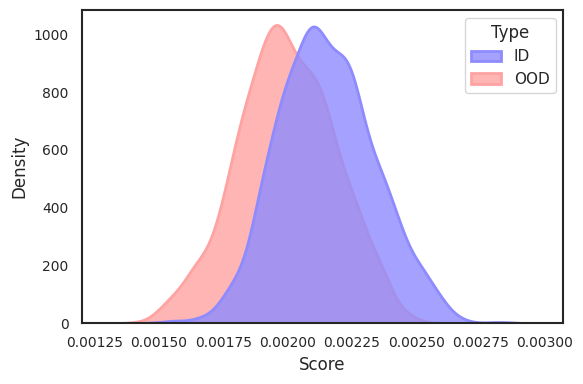

2025-07-13 07:00:57,936 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:00:57,942 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:00:57,955 : & 75.92 & 71.61 & 71.26
DEBUG:__main__:& 75.92 & 71.61 & 71.26
2025-07-13 07:00:57,958 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:00:57,963 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:00:57,968 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:00:57,972 : & 75.92 & 71.61 & 71.26
DEBUG:__main__:& 75.92 & 71.61 & 71.26


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "CUB100_CUB100_50L_75B_finegrained_evaluation",
    "--in_dataset",  "cub100_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "50",
    "--beta",        "0.75",
    "--generate_class",
]
main()

L=100, Beta=0.75

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Laysan Albatross', 'Groove billed Ani', 'Crested Auklet', 'Parakeet Auklet', 'Rusty Blackbird', 'Bobolink', 'Indigo Bunting', 'Painted Bunting', 'Spotted Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'American Crow', 'Purple Finch', 'Acadian Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Gadwall', 'American Goldfinch', 'Boat tailed Grackle', 'Eared Grebe', 'Horned Grebe', 'Pied billed Grebe', 'Blue Grosbeak', 'Evening Grosbeak', 'Pine Grosbeak', 'Rose breasted Grosbeak', 'Pigeon Guillemot', 'Glaucous winged Gull', 'Herring Gull', 'Ivory Gull', 'Ring billed Gull', 'Anna Hummingbird', 'Pomarine Jaeger', 'Blue Jay', 'Green Jay', 'Gray Kingbird', 'Ringed Kingfisher', 'Red legged Kittiwake', 'Horned Lark', 'Western Meadowlark', 'Red breasted Merganser', 'White breasted Nuthatch', 'Hooded Oriole', 'Or

100%|██████████| 12/12 [00:48<00:00,  4.06s/it]
2025-07-13 07:02:03,825 : Evaluating OOD dataset cub100_OOD
DEBUG:__main__:Evaluating OOD dataset cub100_OOD
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 12/12 [00:48<00:00,  4.06s/it]
2025-07-13 07:02:54,627 : in scores: DescribeResult(nobs=2895, minmax=(np.float32(-0.0021431176), np.float32(-0.0011674971)), mean=np.float32(-0.0016948564), variance=np.float64(1.98693732004283e-08), skewness=np.float64(0.02106017805635929), kurtosis=np.float32(-0.07419133))
DEBUG:__main__:in scores: DescribeResult(nobs=2895, minmax=(np.

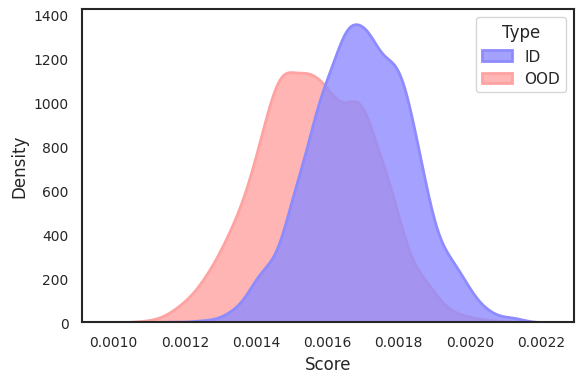

2025-07-13 07:02:55,943 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:02:55,949 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:02:55,959 : & 73.51 & 72.58 & 70.33
DEBUG:__main__:& 73.51 & 72.58 & 70.33
2025-07-13 07:02:55,968 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:02:55,975 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:02:55,982 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:02:55,993 : & 73.51 & 72.58 & 70.33
DEBUG:__main__:& 73.51 & 72.58 & 70.33


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "CUB100_CUB100_100L_75B_finegrained_evaluation",
    "--in_dataset",  "cub100_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "100",
    "--beta",        "0.75",
    "--generate_class",
]
main()

L=300, Beta=0.75

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Laysan Albatross', 'Groove billed Ani', 'Crested Auklet', 'Parakeet Auklet', 'Rusty Blackbird', 'Bobolink', 'Indigo Bunting', 'Painted Bunting', 'Spotted Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'American Crow', 'Purple Finch', 'Acadian Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Gadwall', 'American Goldfinch', 'Boat tailed Grackle', 'Eared Grebe', 'Horned Grebe', 'Pied billed Grebe', 'Blue Grosbeak', 'Evening Grosbeak', 'Pine Grosbeak', 'Rose breasted Grosbeak', 'Pigeon Guillemot', 'Glaucous winged Gull', 'Herring Gull', 'Ivory Gull', 'Ring billed Gull', 'Anna Hummingbird', 'Pomarine Jaeger', 'Blue Jay', 'Green Jay', 'Gray Kingbird', 'Ringed Kingfisher', 'Red legged Kittiwake', 'Horned Lark', 'Western Meadowlark', 'Red breasted Merganser', 'White breasted Nuthatch', 'Hooded Oriole', 'Or

100%|██████████| 12/12 [00:44<00:00,  3.67s/it]
2025-07-13 07:06:40,457 : Evaluating OOD dataset cub100_OOD
DEBUG:__main__:Evaluating OOD dataset cub100_OOD
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 12/12 [00:44<00:00,  3.70s/it]
2025-07-13 07:07:25,222 : in scores: DescribeResult(nobs=2895, minmax=(np.float32(-0.0014762729), np.float32(-0.0008155089)), mean=np.float32(-0.0011401698), variance=np.float64(7.023160178277113e-09), skewness=np.float64(-0.07723482698202133), kurtosis=np.float32(0.1535461))
DEBUG:__main__:in scores: DescribeResult(nobs=2895, minmax=(np.

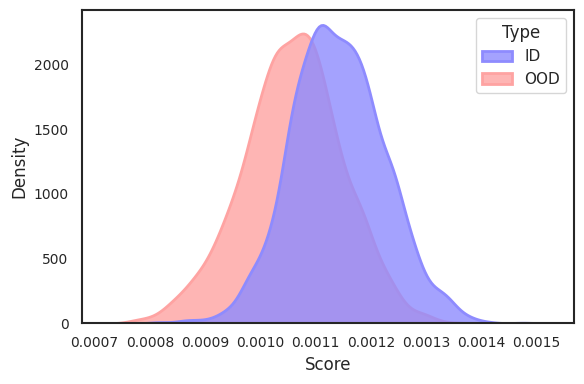

2025-07-13 07:07:26,068 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:07:26,080 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:07:26,084 : & 71.65 & 74.61 & 73.14
DEBUG:__main__:& 71.65 & 74.61 & 73.14
2025-07-13 07:07:26,087 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:07:26,088 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:07:26,095 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:07:26,099 : & 71.65 & 74.61 & 73.14
DEBUG:__main__:& 71.65 & 74.61 & 73.14


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "CUB100_CUB100_300L_75B_finegrained_evaluation",
    "--in_dataset",  "cub100_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "300",
    "--beta",        "0.75",
    "--generate_class",
]
main()

# **RUN EVALUATION PET-19(ID) vs PET-18(OOD) at Beta=0.25 & 0.75,L=0,50,100,300**

In [ ]:
import os
import openai
import re

client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def fetch_synonym(name: str) -> str:
    system_prompt = (
        "You are a fine-grained classification assistant. "
        "When given a pet(including dogs and cats) species name, reply with *exactly one* known synonym or scientific name or name in other language. "
        "If no widely used alternative exists, reply with the original label and do not return *none*. "
        "Only return the name. Do not include explanations, punctuation, or prefixes.\n\n"
        "Here are a few examples:\n"
        "Input: American Goldfinch → Output: Eastern Goldfinch\n"
        "Input: Indigo Bunting → Output: Passerina cyanea\n"
        "Input: Bengal Cat → Output: Leopardette"
        "Input: Gadwall → Output: Anas strepera\n"
    )

    user_prompt = f"Class label: {name}"

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": user_prompt}
        ],
        temperature=0
    )

    raw = response.choices[0].message.content.strip()

    if ":" in raw:
        raw = raw.split(":")[-1].strip()
    if "known as" in raw:
        raw = re.split(r"known as", raw, flags=re.IGNORECASE)[-1].strip()

    return raw.rstrip(".")

In [ ]:
import os
os.environ['CURL_CA_BUNDLE'] = ''
import argparse
import numpy as np
import torch
from scipy import stats

def main():
    args = process_args()
    setup_seed(args.seed)
    log = setup_log(args)
    assert torch.cuda.is_available()
    torch.cuda.set_device(args.gpu)

    net, preprocess = set_model_clip(args)
    net.eval()

    if args.in_dataset.startswith("ImageNet_C"):
        out_datasets = ['iNaturalist', 'SUN', 'places365', 'dtd']
    elif args.in_dataset == 'ImageNet':
        out_datasets = ['iNaturalist', 'SUN', 'places365', 'dtd'] if args.ood_task.startswith("far") else ['ssb_hard', 'ninco']
    else:
        out_datasets = dataset_mappings.get(args.in_dataset, [])

    test_loader = set_val_loader(args, preprocess)
    test_labels = list(get_test_labels(args, test_loader))
    print("Original ID Labels:", test_labels)

    if args.score == 'EOE':
        print("Using LLM-generated OOD candidate classes...")
        base_ood_labels = load_llm_classes(args, test_labels)

        if args.use_synonyms:
            print("Augmenting OOD candidates with synonyms...")

            base_ood_labels = [lbl.strip().lower() for lbl in base_ood_labels]
            original_count = len(base_ood_labels)

            synonym_labels = []
            for lbl in base_ood_labels:
                syn = fetch_synonym(lbl).strip().lower()
                print(f"  → {lbl!r}  → synonym: {syn!r}")
                if syn != lbl:
                    synonym_labels.append(syn)

            combined = base_ood_labels + synonym_labels

            filtered = [label for label in combined if label and label.lower() not in {"none", "null"}]

            removed_count = len(combined) - len(filtered)
            print(f"Removed {removed_count} invalid synonym labels like 'none' or 'null'")

            llm_labels = list(dict.fromkeys(filtered))
            final_count = len(llm_labels)

            print(f"OOD classes before synonym expansion: {original_count}")
            print(f"OOD classes after synonym + deduplication: {final_count}")
        else:
            llm_labels = base_ood_labels
    else:
        llm_labels = []

    print(f"\n Final ID Labels passed to CLIP: {test_labels}")
    print(f"OOD candidate labels: {llm_labels}\n")

    in_score = get_ood_scores_clip(args, net, test_loader, test_labels, llm_labels)

    auroc_list, aupr_list, fpr_list = [], [], []
    for out_dataset in out_datasets:
        log.debug(f"Evaluating OOD dataset {out_dataset}")
        ood_loader = set_ood_loader(args, out_dataset, preprocess)
        out_score = get_ood_scores_clip(args, net, ood_loader, test_labels, llm_labels)

        log.debug(f"in scores: {stats.describe(in_score)}")
        log.debug(f"out scores: {stats.describe(out_score)}")
        plot_distribution(args, in_score, out_score, out_dataset)
        get_and_print_results(args, log, in_score, out_score, auroc_list, aupr_list, fpr_list)

    log.debug('\n\n Mean Test Results')
    print_measures(log, np.mean(auroc_list), np.mean(aupr_list),
                   np.mean(fpr_list), method_name=args.score)

    save_as_dataframe(args, out_datasets, fpr_list, auroc_list, aupr_list)


def process_args():
    parser = argparse.ArgumentParser(
        description='Leverage LLMs for OOD Detection',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument('--in_dataset',
                        default='bird200',
                        choices=ALL_ID_DATASET,
                        help='in-distribution dataset')
    parser.add_argument('--root_dir',
                        default="datasets",
                        help='root dir of datasets')
    # prompt pipeline
    parser.add_argument('--ensemble',
                        action='store_true',
                        default=False,
                        help='CLIP text prompt engineering')
    parser.add_argument('--L',
                        type=int,
                        default=100,
                        help='the length of envisioned OOD class labels, for far/fine-grained: L=500, for near: L=3')
    parser.add_argument('--beta',
                        type=float,
                        default=0.25,
                        help='beta in Eq. 3')
    parser.add_argument('--ood_task',
                        type=str,
                        default='far',
                        choices=ALL_OOD_TASK,
                        help='choose ood task')
    parser.add_argument('--generate_class',
                        action='store_true',
                        help='whether to envision OOD candidate classes or loaded from existing JSONs')
    parser.add_argument('--json_number',
                        type=int,
                        default=0,
                        help='loaded json number')
    parser.add_argument('--llm_model',
                        default="gpt-3.5-turbo",
                        choices=ALL_LLM,
                        help='LLMs')
    parser.add_argument('--name',
                        default="eval_ood",
                        help="unique ID for the run")
    parser.add_argument('--seed',
                        type=int,
                        default=5,
                        help="random seed")
    parser.add_argument('--gpu',
                        type=int,
                        default=0,
                        help='the GPU indice to use')
    parser.add_argument('--batch_size',
                        type=int,
                        default=512,
                        help='mini-batch size')
    parser.add_argument('--T',
                        type=float,
                        default=1,
                        help='score temperature parameter')
    parser.add_argument('--model',
                        default='CLIP',
                        choices=['CLIP'],
                        help='model architecture')
    parser.add_argument('--CLIP_ckpt',
                        default='ViT-B/16',
                        choices=['ViT-B/16'],
                        help='which pretrained img encoder to use')
    parser.add_argument('--score',
                        default='EOE',
                        choices=['EOE', 'MCM', 'energy', 'max-logit'],
                        help='which scoring method')
    parser.add_argument('--score_ablation',
                        default='EOE',
                        choices=['MAX', 'MSP', 'energy', 'max-logit', 'EOE'],
                        help='ablations on the EOE score formula')
    parser.add_argument('--feat_dim',
                        type=int,
                        default=512,
                        help='feat dim, 512 for ViT-B and 768 for ViT-L')
    parser.add_argument('--use_synonyms',
                    default=False,
                    action='store_true',
                    help='Augment ID labels with synonyms using LLM')
    parser.add_argument('--prompt_pool_id',
                    type=int,
                    default=0,
                    help='Which index of openai_imagenet_template_subset to use when --ensemble')
    args = parser.parse_args()

    args.n_cls = get_num_cls(args)
    args.log_directory = f"results/{args.in_dataset}/{args.score}/" \
                         f"{args.model}_{args.CLIP_ckpt}_T_{args.T}_ID_{args.name}"
    os.makedirs(args.log_directory, exist_ok=True)

    return args

L = 0 (MCM)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Havanese', 'Newfoundland', 'Sphynx', 'American Bulldog', 'Samoyed', 'Great Pyrenees', 'Maine Coon', 'Staffordshire Bull Terrier', 'Saint Bernard', 'Bengal', 'Basset Hound', 'Egyptian Mau', 'Shiba Inu', 'Bombay', 'English Cocker Spaniel', 'Japanese Chin', 'Ragdoll', 'Keeshond']
Using original ID labels (no synonyms).
Final ID Labels passed to CLIP: ['Havanese', 'Newfoundland', 'Sphynx', 'American Bulldog', 'Samoyed', 'Great Pyrenees', 'Maine Coon', 'Staffordshire Bull Terrier', 'Saint Bernard', 'Bengal', 'Basset Hound', 'Egyptian Mau', 'Shiba Inu', 'Bombay', 'English Cocker Spaniel', 'Japanese Chin', 'Ragdoll', 'Keeshond']
Envisioned OOD labels (LLM): []


100%|██████████| 7/7 [03:32<00:00, 30.30s/it]
2025-07-13 07:14:05,981 : Evaluating OOD dataset pet19_OOD
DEBUG:__main__:Evaluating OOD dataset pet19_OOD
100%|██████████| 8/8 [03:06<00:00, 23.35s/it]
2025-07-13 07:17:13,202 : in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.06711034), np.float32(-0.05786178)), mean=np.float32(-0.062342525), variance=np.float64(2.5616849217940953e-06), skewness=np.float64(-0.044997088611125946), kurtosis=np.float32(-0.024773598))
DEBUG:__main__:in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.06711034), np.float32(-0.05786178)), mean=np.float32(-0.062342525), variance=np.float64(2.5616849217940953e-06), skewness=np.float64(-0.044997088611125946), kurtosis=np.float32(-0.024773598))
2025-07-13 07:17:13,206 : out scores: DescribeResult(nobs=1896, minmax=(np.float32(-0.063923106), np.float32(-0.056614745)), mean=np.float32(-0.06014493), variance=np.float64(1.9639668847823708e-06), skewness=np.float64(-0.02950146421790123), kurtosis=np.flo

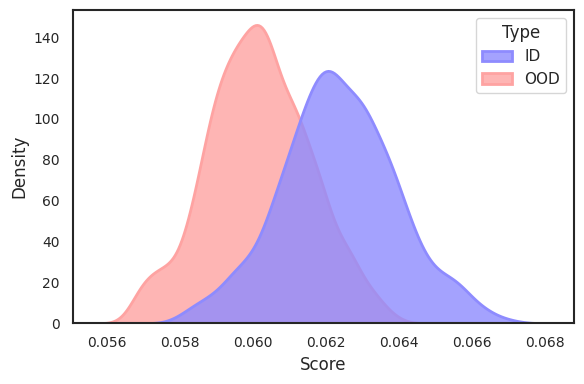

2025-07-13 07:17:13,497 : 				MCM
DEBUG:__main__:				MCM
2025-07-13 07:17:13,499 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:17:13,501 : & 64.03 & 84.88 & 85.07
DEBUG:__main__:& 64.03 & 84.88 & 85.07
2025-07-13 07:17:13,503 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:17:13,505 : 				MCM
DEBUG:__main__:				MCM
2025-07-13 07:17:13,507 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:17:13,508 : & 64.03 & 84.88 & 85.07
DEBUG:__main__:& 64.03 & 84.88 & 85.07


In [ ]:
!pip install -q nest_asyncio
import nest_asyncio
nest_asyncio.apply()
import os
os.environ['CURL_CA_BUNDLE'] = ''
import argparse
import numpy as np
import torch
from scipy import stats
import sys

sys.argv = [
    "eval_ood_detection.py",
    "--name",        "PET19_PET18_MCM_finegrained_evaluation",
    "--in_dataset",  "pet18_ID",
    "--ood_task",    "fine_grained",
    "--score",       "MCM",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "50",
]
main()

L=50, Beta=0.25

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Havanese', 'Newfoundland', 'Sphynx', 'American Bulldog', 'Samoyed', 'Great Pyrenees', 'Maine Coon', 'Staffordshire Bull Terrier', 'Saint Bernard', 'Bengal', 'Basset Hound', 'Egyptian Mau', 'Shiba Inu', 'Bombay', 'English Cocker Spaniel', 'Japanese Chin', 'Ragdoll', 'Keeshond']
Using original ID labels (no synonyms).
Envisioning Outlier Exposure...
🔵 Generating via OpenAI GPT...
🔍 Raw GPT output:
 - Siamese
        - Persian
        - Chihuahua
        - Cavalier King Charles Spaniel
        - Russian Blue
        - Bernese Mountain Dog
        - Siamese
        - Abyssinian
        - Pomeranian
        - Scottish Fold
        - Maltese
        - Ragamuffin
        - Tibetan Mastiff
        - Cornish Rex
        - Papillon
        - Devon Rex
        - Toyger
        - Australian Terrier
        - Havana Brown
        - Chartreux
        - American Shorthair
        - Australian Cattle Dog
        - Birman
        - Manx
        - Norwegian Forest Cat
        - Aus

100%|██████████| 7/7 [00:34<00:00,  4.87s/it]
2025-07-13 07:18:02,797 : Evaluating OOD dataset pet19_OOD
DEBUG:__main__:Evaluating OOD dataset pet19_OOD
100%|██████████| 8/8 [00:33<00:00,  4.22s/it]
2025-07-13 07:18:37,134 : in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.018066352), np.float32(-0.014347032)), mean=np.float32(-0.016307302), variance=np.float64(3.869365508092653e-07), skewness=np.float64(0.3710338771343231), kurtosis=np.float32(0.14221573))
DEBUG:__main__:in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.018066352), np.float32(-0.014347032)), mean=np.float32(-0.016307302), variance=np.float64(3.869365508092653e-07), skewness=np.float64(0.3710338771343231), kurtosis=np.float32(0.14221573))
2025-07-13 07:18:37,138 : out scores: DescribeResult(nobs=1896, minmax=(np.float32(-0.016965497), np.float32(-0.014223428)), mean=np.float32(-0.0153955035), variance=np.float64(2.637809195753791e-07), skewness=np.float64(-0.41187214851379395), kurtosis=np.float32(-0

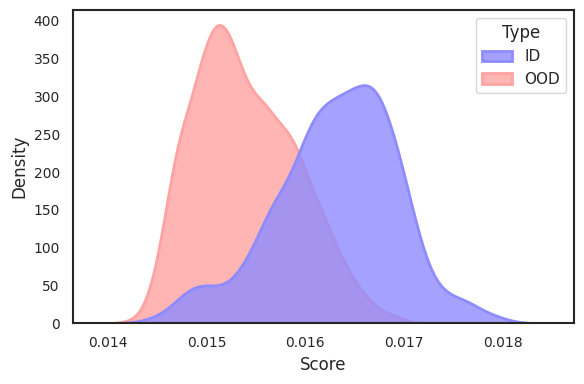

2025-07-13 07:18:37,416 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:18:37,418 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:18:37,420 : & 67.88 & 86.52 & 87.35
DEBUG:__main__:& 67.88 & 86.52 & 87.35
2025-07-13 07:18:37,421 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:18:37,423 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:18:37,430 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:18:37,435 : & 67.88 & 86.52 & 87.35
DEBUG:__main__:& 67.88 & 86.52 & 87.35


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "PET19_PET18_50L_25B_finegrained_evaluation",
    "--in_dataset",  "pet18_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "50",
    "--generate_class",
]
main()

L=100, Beta=0.25

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Havanese', 'Newfoundland', 'Sphynx', 'American Bulldog', 'Samoyed', 'Great Pyrenees', 'Maine Coon', 'Staffordshire Bull Terrier', 'Saint Bernard', 'Bengal', 'Basset Hound', 'Egyptian Mau', 'Shiba Inu', 'Bombay', 'English Cocker Spaniel', 'Japanese Chin', 'Ragdoll', 'Keeshond']
Using original ID labels (no synonyms).
Envisioning Outlier Exposure...
🔵 Generating via OpenAI GPT...
Continuing vision 1/1
🔍 Raw GPT output:
 - Siamese
- Persian
- Chihuahua
- Siamese
- Pomeranian
- Abyssinian
- Cavalier King Charles Spaniel
- Russian Blue
- Maltese
- Ragamuffin
- Scottish Fold
- Papillon
- Cornish Rex
- Devon Rex
- Manx
- Birman
- Burmese
- Chartreux
- Havana Brown
- Tonkinese
- Turkish Angora
- Turkish Van
- American Shorthair
- British Shorthair
- Exotic Shorthair
- Himalayan
- Javanese
- Korat
- LaPerm
- Norwegian Forest Cat
- Ocicat
- Oriental
- Russian Black
- Russian White
- Scottish Fold
- Selkirk Rex
- Singapura
- Snowshoe
- Somali
- Sphynx
- Tonkinese
- Toyger
- 

100%|██████████| 7/7 [00:31<00:00,  4.50s/it]
2025-07-13 07:19:28,013 : Evaluating OOD dataset pet19_OOD
DEBUG:__main__:Evaluating OOD dataset pet19_OOD
100%|██████████| 8/8 [00:34<00:00,  4.32s/it]
2025-07-13 07:20:03,142 : in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.012441447), np.float32(-0.009983833)), mean=np.float32(-0.011301999), variance=np.float64(1.8139508603990662e-07), skewness=np.float64(0.3772919178009033), kurtosis=np.float32(0.015617132))
DEBUG:__main__:in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.012441447), np.float32(-0.009983833)), mean=np.float32(-0.011301999), variance=np.float64(1.8139508603990662e-07), skewness=np.float64(0.3772919178009033), kurtosis=np.float32(0.015617132))
2025-07-13 07:20:03,164 : out scores: DescribeResult(nobs=1896, minmax=(np.float32(-0.011727629), np.float32(-0.009900528)), mean=np.float32(-0.010653372), variance=np.float64(1.20319748265619e-07), skewness=np.float64(-0.35016393661499023), kurtosis=np.float32(

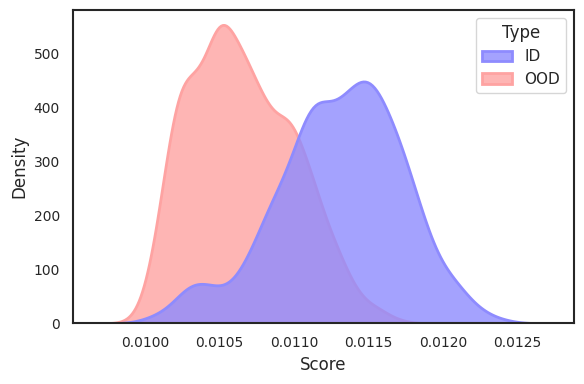

2025-07-13 07:20:04,523 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:20:04,531 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:20:04,537 : & 66.19 & 87.51 & 88.53
DEBUG:__main__:& 66.19 & 87.51 & 88.53
2025-07-13 07:20:04,548 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:20:04,552 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:20:04,559 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:20:04,562 : & 66.19 & 87.51 & 88.53
DEBUG:__main__:& 66.19 & 87.51 & 88.53


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "PET19_PET18_100L_25B_finegrained_evaluation",
    "--in_dataset",  "pet18_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "100",
    "--generate_class",
]
main()

L=300, Beta=0.25

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Havanese', 'Newfoundland', 'Sphynx', 'American Bulldog', 'Samoyed', 'Great Pyrenees', 'Maine Coon', 'Staffordshire Bull Terrier', 'Saint Bernard', 'Bengal', 'Basset Hound', 'Egyptian Mau', 'Shiba Inu', 'Bombay', 'English Cocker Spaniel', 'Japanese Chin', 'Ragdoll', 'Keeshond']
Using original ID labels (no synonyms).
Envisioning Outlier Exposure...
🔵 Generating via OpenAI GPT...
Continuing vision 1/5
Continuing vision 2/5
Continuing vision 3/5
Continuing vision 4/5
Continuing vision 5/5
🔍 Raw GPT output:
 - Siamese
- Persian
- Chihuahua
- Siamese
- Pomeranian
- Abyssinian
- Cavalier King Charles Spaniel
- Russian Blue
- Maltese
- Ragamuffin
- Scottish Fold
- Papillon
- Cornish Rex
- Toyger
- Devon Rex
- Birman
- Manx
- Chartreux
- Havana Brown
- Tonkinese
- American Shorthair
- Burmese
- Turkish Angora
- Singapura
- Balinese
- Ocicat
- American Wirehair
- Turkish Van
- Exotic Shorthair
- Somali
- American Curl
- British Shorthair
- Norwegian Forest Cat
- Bombay
- H

100%|██████████| 7/7 [00:33<00:00,  4.80s/it]
2025-07-13 07:21:12,229 : Evaluating OOD dataset pet19_OOD
DEBUG:__main__:Evaluating OOD dataset pet19_OOD
100%|██████████| 8/8 [00:31<00:00,  3.99s/it]
2025-07-13 07:21:44,486 : in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.005833069), np.float32(-0.0048058173)), mean=np.float32(-0.0053805755), variance=np.float64(2.7000522720578384e-08), skewness=np.float64(0.5088456869125366), kurtosis=np.float32(0.65659714))
DEBUG:__main__:in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.005833069), np.float32(-0.0048058173)), mean=np.float32(-0.0053805755), variance=np.float64(2.7000522720578384e-08), skewness=np.float64(0.5088456869125366), kurtosis=np.float32(0.65659714))
2025-07-13 07:21:44,493 : out scores: DescribeResult(nobs=1896, minmax=(np.float32(-0.005568591), np.float32(-0.0046895407)), mean=np.float32(-0.00507875), variance=np.float64(2.6078133389228603e-08), skewness=np.float64(-0.2473400980234146), kurtosis=np.float

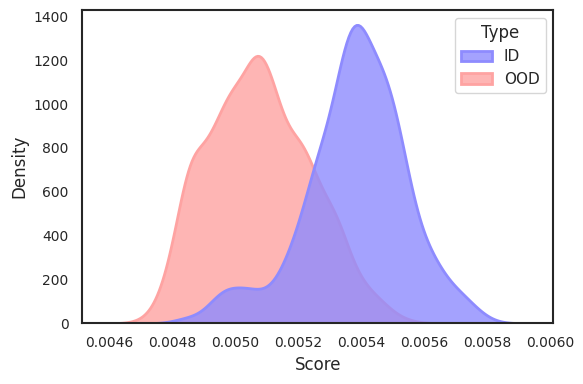

2025-07-13 07:21:45,352 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:21:45,364 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:21:45,375 : & 55.85 & 89.98 & 90.13
DEBUG:__main__:& 55.85 & 89.98 & 90.13
2025-07-13 07:21:45,382 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:21:45,392 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:21:45,401 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:21:45,408 : & 55.85 & 89.98 & 90.13
DEBUG:__main__:& 55.85 & 89.98 & 90.13


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "PET19_PET18_300L_25B_finegrained_evaluation",
    "--in_dataset",  "pet18_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "300",
    "--generate_class",
]
main()

L=50, Beta=0.75

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Havanese', 'Newfoundland', 'Sphynx', 'American Bulldog', 'Samoyed', 'Great Pyrenees', 'Maine Coon', 'Staffordshire Bull Terrier', 'Saint Bernard', 'Bengal', 'Basset Hound', 'Egyptian Mau', 'Shiba Inu', 'Bombay', 'English Cocker Spaniel', 'Japanese Chin', 'Ragdoll', 'Keeshond']
Using original ID labels (no synonyms).
Envisioning Outlier Exposure...
🔵 Generating via OpenAI GPT...
🔍 Raw GPT output:
 - Siamese
- Persian
- Chihuahua
- Siamese
- Pomeranian
- Abyssinian
- Cavalier King Charles Spaniel
- Russian Blue
- Maltese
- Ragamuffin
- Scottish Fold
- Cavalier King Charles Spaniel
- Cornish Rex
- Papillon
- Devon Rex
- Tibetan Mastiff
- Manx
- Toyger
- Chartreux
- Tibetan Spaniel
- Singapura
- American Shorthair
- Australian Terrier
- Birman
- Burmese
- Chartreux
- Havana Brown
- Himalayan
- Korat
- LaPerm
- Munchkin
- Nebelung
- Ocicat
- Oriental
- Russian Blue
- Scottish Fold
- Selkirk Rex
- Snowshoe
- Somali
- Tonkinese
- Turkish Angora
- Turkish Van
- American C

100%|██████████| 7/7 [00:31<00:00,  4.50s/it]
2025-07-13 07:22:30,748 : Evaluating OOD dataset pet19_OOD
DEBUG:__main__:Evaluating OOD dataset pet19_OOD
100%|██████████| 8/8 [00:34<00:00,  4.28s/it]
2025-07-13 07:23:05,581 : in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.0065724645), np.float32(-0.0033037849)), mean=np.float32(-0.004930416), variance=np.float64(3.561373313816084e-07), skewness=np.float64(0.12698684632778168), kurtosis=np.float32(-0.4544747))
DEBUG:__main__:in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.0065724645), np.float32(-0.0033037849)), mean=np.float32(-0.004930416), variance=np.float64(3.561373313816084e-07), skewness=np.float64(0.12698684632778168), kurtosis=np.float32(-0.4544747))
2025-07-13 07:23:05,587 : out scores: DescribeResult(nobs=1896, minmax=(np.float32(-0.005712309), np.float32(-0.0026333174)), mean=np.float32(-0.0041007535), variance=np.float64(3.6060193756468243e-07), skewness=np.float64(-0.3636261820793152), kurtosis=np.flo

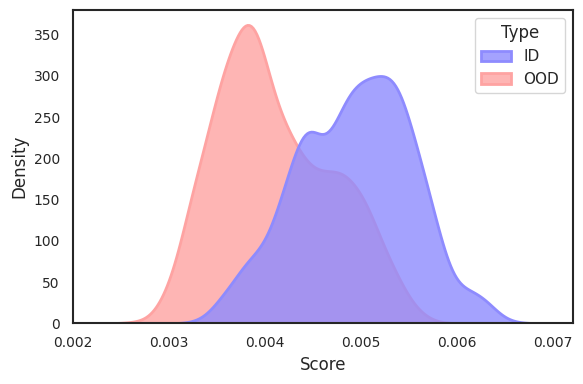

2025-07-13 07:23:05,883 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:23:05,885 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:23:05,888 : & 57.23 & 82.97 & 82.02
DEBUG:__main__:& 57.23 & 82.97 & 82.02
2025-07-13 07:23:05,890 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:23:05,892 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:23:05,894 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:23:05,895 : & 57.23 & 82.97 & 82.02
DEBUG:__main__:& 57.23 & 82.97 & 82.02


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "PET19_PET18_50L_75B_finegrained_evaluation",
    "--in_dataset",  "pet18_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "50",
    "--beta",        "0.75",
    "--generate_class",
]
main()

L=100, Beta=0.75

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Havanese', 'Newfoundland', 'Sphynx', 'American Bulldog', 'Samoyed', 'Great Pyrenees', 'Maine Coon', 'Staffordshire Bull Terrier', 'Saint Bernard', 'Bengal', 'Basset Hound', 'Egyptian Mau', 'Shiba Inu', 'Bombay', 'English Cocker Spaniel', 'Japanese Chin', 'Ragdoll', 'Keeshond']
Using original ID labels (no synonyms).
Envisioning Outlier Exposure...
🔵 Generating via OpenAI GPT...
Continuing vision 1/1
🔍 Raw GPT output:
 - Siamese
- Persian
- Chihuahua
- Siamese
- Pomeranian
- Abyssinian
- Cavalier King Charles Spaniel
- Russian Blue
- Maltese
- Ragamuffin
- Scottish Fold
- Cavalier King Charles Spaniel
- Cornish Rex
- Papillon
- Devon Rex
- Tibetan Mastiff
- Manx
- Toyger
- Chartreux
- American Shorthair
- Australian Terrier
- Birman
- Burmese
- Chartreux
- Exotic Shorthair
- Havana Brown
- Himalayan
- Korat
- LaPerm
- Munchkin
- Nebelung
- Ocicat
- Oriental
- Russian Blue
- Scottish Fold
- Selkirk Rex
- Singapura
- Snowshoe
- Somali
- Tonkinese
- Turkish Angora
- T

100%|██████████| 7/7 [00:31<00:00,  4.50s/it]
2025-07-13 07:23:56,777 : Evaluating OOD dataset pet19_OOD
DEBUG:__main__:Evaluating OOD dataset pet19_OOD
100%|██████████| 8/8 [00:36<00:00,  4.52s/it]
2025-07-13 07:24:33,458 : in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.0033014603), np.float32(-0.0019043805)), mean=np.float32(-0.0026900754), variance=np.float64(6.004829006043407e-08), skewness=np.float64(0.1921277791261673), kurtosis=np.float32(-0.07983565))
DEBUG:__main__:in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.0033014603), np.float32(-0.0019043805)), mean=np.float32(-0.0026900754), variance=np.float64(6.004829006043407e-08), skewness=np.float64(0.1921277791261673), kurtosis=np.float32(-0.07983565))
2025-07-13 07:24:33,464 : out scores: DescribeResult(nobs=1896, minmax=(np.float32(-0.0031186864), np.float32(-0.0014173146)), mean=np.float32(-0.0022334864), variance=np.float64(9.113740876839703e-08), skewness=np.float64(-0.18687671422958374), kurtosis=np.

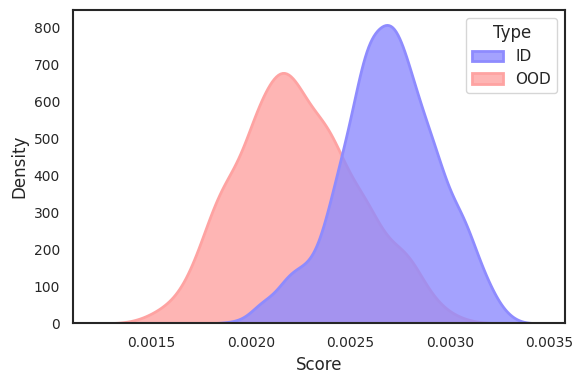

2025-07-13 07:24:33,891 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:24:33,894 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:24:33,898 : & 45.89 & 87.37 & 84.98
DEBUG:__main__:& 45.89 & 87.37 & 84.98
2025-07-13 07:24:33,900 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:24:33,901 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:24:33,904 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:24:33,906 : & 45.89 & 87.37 & 84.98
DEBUG:__main__:& 45.89 & 87.37 & 84.98


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "PET19_PET18_100L_75B_finegrained_evaluation",
    "--in_dataset",  "pet18_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "100",
    "--beta",        "0.75",
    "--generate_class",
]
main()

L=300, Beta=0.75

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Original ID Labels: ['Havanese', 'Newfoundland', 'Sphynx', 'American Bulldog', 'Samoyed', 'Great Pyrenees', 'Maine Coon', 'Staffordshire Bull Terrier', 'Saint Bernard', 'Bengal', 'Basset Hound', 'Egyptian Mau', 'Shiba Inu', 'Bombay', 'English Cocker Spaniel', 'Japanese Chin', 'Ragdoll', 'Keeshond']
Using original ID labels (no synonyms).
Envisioning Outlier Exposure...
🔵 Generating via OpenAI GPT...
Continuing vision 1/5
Continuing vision 2/5
Continuing vision 3/5
Continuing vision 4/5
Continuing vision 5/5
🔍 Raw GPT output:
 - Siamese
        - Persian
        - Chihuahua
        - Siamese Fighting Fish
        - Ferret
        - Guinea Pig
        - Hamster
        - Parrot
        - Rabbit
        - Turtle
        - Gecko
        - Iguana
        - Cockatiel
        - Cockatoo
        - Macaw
        - Finch
        - Canary
        - Lovebird
        - Budgerigar
        - Parakeet
        - Hermit Crab
        - Axolotl
        - Tarantula
        - Hedgehog
        - Sugar Glider

100%|██████████| 7/7 [00:32<00:00,  4.71s/it]
2025-07-13 07:25:31,045 : Evaluating OOD dataset pet19_OOD
DEBUG:__main__:Evaluating OOD dataset pet19_OOD
100%|██████████| 8/8 [00:31<00:00,  3.89s/it]
2025-07-13 07:26:03,294 : in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.00726112), np.float32(-0.0038728565)), mean=np.float32(-0.00579497), variance=np.float64(3.763825344215714e-07), skewness=np.float64(0.5781721472740173), kurtosis=np.float32(-0.09235215))
DEBUG:__main__:in scores: DescribeResult(nobs=1773, minmax=(np.float32(-0.00726112), np.float32(-0.0038728565)), mean=np.float32(-0.00579497), variance=np.float64(3.763825344215714e-07), skewness=np.float64(0.5781721472740173), kurtosis=np.float32(-0.09235215))
2025-07-13 07:26:03,299 : out scores: DescribeResult(nobs=1896, minmax=(np.float32(-0.006567549), np.float32(-0.0031413734)), mean=np.float32(-0.0048802877), variance=np.float64(4.579562575700782e-07), skewness=np.float64(0.1535322517156601), kurtosis=np.float32(-0.

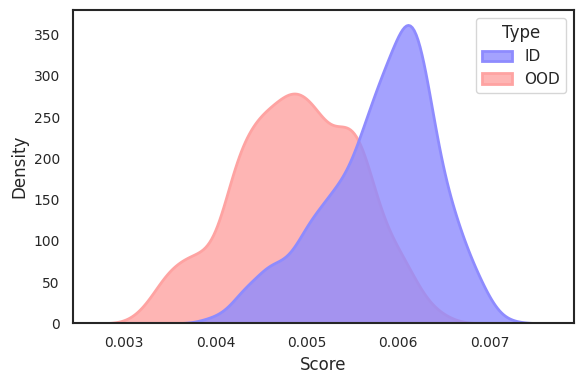

2025-07-13 07:26:03,602 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:26:03,606 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:26:03,608 : & 65.82 & 83.98 & 84.27
DEBUG:__main__:& 65.82 & 83.98 & 84.27
2025-07-13 07:26:03,609 : 

Mean Test Results
DEBUG:__main__:

Mean Test Results
2025-07-13 07:26:03,611 : 				EOE
DEBUG:__main__:				EOE
2025-07-13 07:26:03,613 :   FPR95 AUROC AUPR
DEBUG:__main__:  FPR95 AUROC AUPR
2025-07-13 07:26:03,615 : & 65.82 & 83.98 & 84.27
DEBUG:__main__:& 65.82 & 83.98 & 84.27


In [ ]:
sys.argv = [
    "eval_ood_detection.py",
    "--name",        "PET19_PET18_300L_75B_finegrained_evaluation",
    "--in_dataset",  "pet18_ID",
    "--ood_task",    "fine_grained",
    "--score",       "EOE",
    "--root_dir",    "datasets",
    "--batch_size",  "256",
    "--gpu",         "0",
    "--L",           "300",
    "--beta",        "0.75",
    "--generate_class",
]
main()